In [195]:
import pandas as pd
import os
import pathlib
import joblib
from fredapi import Fred
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import json


# Load FRED API key from .env file
env_path = pathlib.Path('..') / '.env'
load_dotenv(dotenv_path=env_path)
FRED_API_KEY = os.getenv("FRED_API_KEY")
fred = Fred(api_key=FRED_API_KEY)

# Define series to fetch from FRED
series_dict = {
    'gdp': ('GDP', 'Q'),
    'cpi': ('CPIAUCSL', 'M'),
    'unrate': ('UNRATE', 'M'),
    'fedrate': ('FEDFUNDS', 'M'),
}

# Fetch data from FRED
data = pd.DataFrame()
for var_name, (series_id, freq) in series_dict.items():
    series_data = fred.get_series(series_id)
    data[var_name] = series_data

# Resample monthly data to quarterly and calculate additional variables
data_q = pd.DataFrame()
data_q['fedrate'] = data['fedrate'].resample('Q').mean()
data_q['gdp'] = data['gdp'].resample('Q').last()
data_q['unrate'] = data['unrate'].resample('Q').mean()
data_q['cpi'] = data['cpi'].resample('Q').mean()
data_q['cpi_pct'] = data_q['cpi'].pct_change() * 100
data_q['gdp_pct'] = data_q['gdp'].pct_change() * 100
data_q['gdp_pct_ma4'] = data_q['gdp_pct'].rolling(window=4).mean()

# Define start and end dates
start_date = '1955-01-01'
end_date = '2022-12-31'

# Filter data based on specified date range
data_input = data_q[['fedrate', 'gdp', 'gdp_pct', 'gdp_pct_ma4', 'cpi', 'cpi_pct', 'unrate']].copy()
data_input['fedrate_change'] = data_input['fedrate'].diff()
data_input['target'] = (data_input['fedrate_change'] > 0).astype(int)

# Extend the start date to include additional rows for lag features
extended_start_date = pd.to_datetime(start_date) - pd.DateOffset(months=6)  # extend by two quarters
data_input = data_input.loc[extended_start_date:end_date]

# Apply lag operations
# data_input['cpi_pct_lag1'] = data_input['cpi_pct'].shift(1)
# data_input['cpi_pct_lag2'] = data_input['cpi_pct'].shift(2)
# data_input['unrate_lag1'] = data_input['unrate'].shift(1)
# data_input['unrate_lag2'] = data_input['unrate'].shift(2)

# Filter the data again to the desired date range
df = data_input.loc[start_date:end_date]
df = df[['target',  'cpi_pct', 'unrate']]

# df.head()


Intercept (b0): 0.12158722141619807
Coefficient for CPI percentage change (b1): 0.2606272700499551
Coefficient for Unemployment Rate (b2): -0.4077992157021324


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69        26
           1       0.73      0.66      0.69        29

    accuracy                           0.69        55
   macro avg       0.69      0.69      0.69        55
weighted avg       0.70      0.69      0.69        55



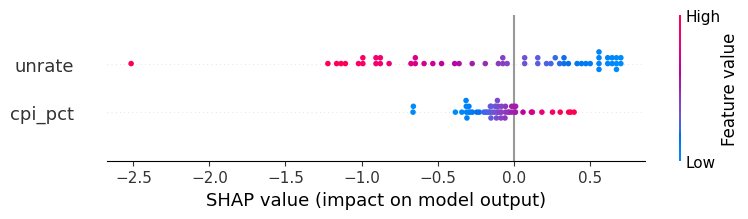

In [197]:
import plotly.express as px
import plotly.io as pio
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
import plotly.graph_objects as go

# Assume df is your preprocessed DataFrame
X = df[['cpi_pct', 'unrate']]
y = df['target']

# Split the dataset while preserving time order
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Standardize the features (important for models like logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)
log_reg_preds = log_reg_model.predict(X_test_scaled)

intercept = log_reg_model.intercept_[0]
coef_cpi_pct, coef_unrate = log_reg_model.coef_[0]

print(f"Intercept (b0): {intercept}")
print(f"Coefficient for CPI percentage change (b1): {coef_cpi_pct}")
print(f"Coefficient for Unemployment Rate (b2): {coef_unrate}")

# ROC Curve and AUC Score
log_reg_probs = log_reg_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, log_reg_probs)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve using Plotly
roc_fig = px.line(
    x=fpr,
    y=tpr,
    labels={'x': 'False Positive Rate', 'y': 'True Positive Rate'},
    title='Receiver Operating Characteristic',
    width=600,
    height=600
)
roc_fig.add_shape(
    type='line',
    line=dict(dash='dash', color='navy'),
    x0=0, x1=1, y0=0, y1=1
)
roc_fig.add_annotation(
    x=0, y=1,
    text=f'AUC: {roc_auc:.2f}',
    showarrow=False
)
roc_fig.show()

# Convert ROC plot to JSON
roc_curve_json = pio.to_json(roc_fig)

# Print Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_preds))

# SHAP Values (explaining the model's predictions)
explainer = shap.Explainer(log_reg_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP Values
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Convert SHAP values to a format that can be displayed in a Plotly waterfall chart
shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_df = shap_df.mean(axis=0).reset_index()
shap_df.columns = ['Feature', 'SHAP Value']
shap_df = shap_df.sort_values(by='SHAP Value', ascending=False)

# Plotting SHAP Values using Plotly Express
shap_fig = px.bar(shap_df, x='SHAP Value', y='Feature', orientation='h', title='SHAP Values')
shap_fig.show()

# Convert SHAP plot to JSON
shap_json = pio.to_json(shap_fig)

# Assuming shap_json contains your SHAP plot data
data_to_save = {
    'shap_plot_data': shap_json,
    'roc_curve_data': roc_curve_json
}

with open('plot_data.json', 'w') as f:
    json.dump(data_to_save, f)


In [35]:
joblib.dump(log_reg_model, 'fed_model.pkl')
joblib.dump(scaler, 'fed_scaler.pkl')

['fed_scaler.pkl']

In [6]:
unemp = fred.get_series('UNRATE')
last_unemp = unemp.iloc[-1]

In [16]:
import numpy as np
logistic_regression = joblib.load('fed_model.pkl')
scaler = joblib.load('fed_scaler.pkl')

feature_values = np.array([[0.8783593570337533, 3.8]])
feature_values_scaled = scaler.transform(feature_values)
feature_names = ['cpi', 'unemp']
X_test = pd.DataFrame(feature_values_scaled, columns=feature_names)
probability = logistic_regression.predict_proba(X_test)
print(probability)

[[0.34013502 0.65986498]]


X does not have valid feature names, but StandardScaler was fitted with feature names
X has feature names, but LogisticRegression was fitted without feature names
